In [1]:
import kagglehub

path = kagglehub.dataset_download("kritanjalijain/amazon-reviews")

print("Path to dataset files:", path) # downloading data

Path to dataset files: /kaggle/input/amazon-reviews


In [2]:
import pandas as pd
import os
file_path_test = os.path.join(path, 'test.csv') #Finding path of files for train and test
file_path_train = os.path.join(path, 'train.csv')

amazon_rew_pd_train = pd.read_csv(file_path_train, header=None) #DataFrame for train
amazon_rew_pd_test = pd.read_csv(file_path_test, header=None) #DataFrame for test

amazon_rew_pd_train.columns = ["label", "title", "text"]
amazon_rew_pd_test.columns = ["label", "title", "text"]
#Firstly we will work with train data

In [4]:
amazon_rew_pd_train.head() #show 5 element

,label,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [5]:
amazon_rew_pd_test.head()

,label,title,text
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [6]:
amazon_rew_pd_train.columns

Index(['label', 'title', 'text'], dtype='object')

In [3]:
import re

def clean_text(text):
  text = re.sub(r"<.*?>", "", text)
  text = re.sub(r"[^\w\s]", "", text)
  return text.lower()

amazon_rew_pd_train["text"] = amazon_rew_pd_train["text"].apply(clean_text)
amazon_rew_pd_test["text"] = amazon_rew_pd_test["text"].apply(clean_text)

In [8]:
amazon_rew_pd_train.head()

,label,title,text
0,2,Stuning even for the non-gamer,this sound track was beautiful it paints the s...
1,2,The best soundtrack ever to anything.,im reading a lot of reviews saying that this i...
2,2,Amazing!,this soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,i truly like this soundtrack and i enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...",if youve played the game you know how divine t...


In [9]:
amazon_rew_pd_train['label'].value_counts()

label
2    1800000
1    1800000
Name: count, dtype: int64

In [4]:
amazon_rew_pd_train['label'] = amazon_rew_pd_train['label'].replace({2: 1, 1: 0})
amazon_rew_pd_test['label'] = amazon_rew_pd_test['label'].replace({2: 1, 1: 0})

In [11]:
amazon_rew_pd_train['text_length'] = amazon_rew_pd_train['text'].apply(len)
amazon_rew_pd_train['text_length'].describe()

count    3.600000e+06
mean     3.926362e+02
std      2.272229e+02
min      0.000000e+00
25%      2.010000e+02
50%      3.450000e+02
75%      5.480000e+02
max      9.960000e+02
Name: text_length, dtype: float64

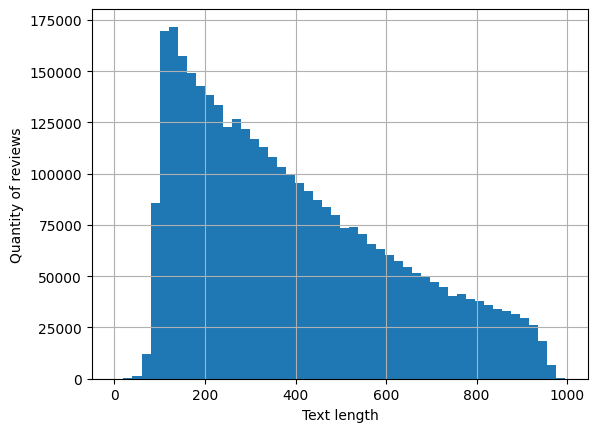

In [12]:
import matplotlib.pyplot as plt

amazon_rew_pd_train['text_length'].hist(bins=50)
plt.xlabel('Text length')
plt.ylabel('Quantity of reviews')
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    amazon_rew_pd_train['text'],
    amazon_rew_pd_train['label'],
    test_size=0.2,
    random_state=42,
    stratify=amazon_rew_pd_train['label']
)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(amazon_rew_pd_train['text'])
X_test_tfidf = tfidf.fit_transform(amazon_rew_pd_test['text'])

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_tfidf, amazon_rew_pd_train['label'])

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [16]:
print(amazon_rew_pd_train["label"].value_counts())
print(amazon_rew_pd_test["label"].value_counts())

label
1    1800000
0    1800000
Name: count, dtype: int64
label
1    200000
0    200000
Name: count, dtype: int64


In [17]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_tfidf)

print(classification_report(amazon_rew_pd_test['label'], y_pred))

              precision    recall  f1-score   support

           0       0.54      0.71      0.62    200000
           1       0.58      0.40      0.47    200000

    accuracy                           0.56    400000
   macro avg       0.56      0.56      0.55    400000
weighted avg       0.56      0.56      0.55    400000



In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 2000
max_lenght = 300
padding_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [19]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(amazon_rew_pd_test["text"])

X_train_padded = pad_sequences(X_train_seq, maxlen=max_lenght, padding=padding_type, truncating=trunc_type)
X_val_padded = pad_sequences(X_val_seq, maxlen=max_lenght, padding=padding_type, truncating=trunc_type)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_lenght, padding=padding_type, truncating=trunc_type)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(vocab_size, 128),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, max_lenght))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 128)       │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 387,713 (1.48 MB)

 Trainable params: 387,713 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(
    X_train_padded, y_train,
    validation_data=(X_val_padded, y_val),
    epochs=5,
    batch_size=32,
    verbose=2
)

Epoch 1/5
90000/90000 - 1649s - 18ms/step - accuracy: 0.5000 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/5
90000/90000 - 1640s - 18ms/step - accuracy: 0.5000 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/5
90000/90000 - 1641s - 18ms/step - accuracy: 0.4998 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/5
90000/90000 - 1698s - 19ms/step - accuracy: 0.4998 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/5
90000/90000 - 1637s - 18ms/step - accuracy: 0.5004 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6932


In [23]:
test_loss, test_accuracy = model.evaluate(X_test_padded, amazon_rew_pd_test['label'], verbose=2)
print(f'Test accuracy: {test_accuracy:.2f}')

12500/12500 - 90s - 7ms/step - accuracy: 0.5000 - loss: 0.6932
Test accuracy: 0.50


In [6]:
import requests

try:
    response = requests.get("https://huggingface.co/bert-base-uncased")
    print("Internet connection is available.")
except:
    print("No internet connection!")

Internet connection is available.


In [7]:
import numpy as np

def batch_tokenize(texts, tokenizer, batch_size=1000, max_length=128):
  tokens = {"input_ids": [], "attention_mask": []}
  for i in range(0, len(texts), batch_size):
      batch = texts[i:i+batch_size]
      tokenized = tokenizer(
          batch,
          max_length=max_length,
          padding=True,
          truncation=True,
          return_tensors='tf'
      )
      tokens['input_ids'].append(tokenized['input_ids'])
      tokens['attention_mask'].append(tokenized['attention_mask'])
  tokens['input_ids'] = np.concatenate(tokens['input_ids'], axis=0)
  tokens['attention_mask'] = np.concatenate(tokens['attention_mask'], axis=0)
  return tokens

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
X_train_tokens = batch_tokenize(list(X_train), tokenizer)
X_val_tokens = batch_tokenize(list(X_val), tokenizer)
X_test_tokens = batch_tokenize(list(amazon_rew_pd_test["text"]), tokenizer)

In [10]:
from transformers import TFBertForSequenceClassification
from transformers.optimization_tf import AdamWeightDecay
from tensorflow.keras.losses import BinaryCrossentropy

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)
model.compile(
    optimizer=optimizer,
    loss=BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)
model.summary()

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
print(type(y_train))  
print(y_train[:5]) 
print(X_val_tokens['input_ids'].shape)  
print(y_val.shape)

<class 'pandas.core.series.Series'>
3465247    1
3191086    0
2966080    0
1001353    1
3057364    1
Name: label, dtype: int64
(720000, 128)
(720000,)


In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    X_train_tokens['input_ids'],
    tf.convert_to_tensor(y_train, dtype=tf.int32)
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    X_val_tokens['input_ids'],
    tf.convert_to_tensor(y_val, dtype=tf.int32)
))

train_dataset = train_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)

Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 90801/180000 [==============>...............] - ETA: 6:35:22 - loss: 7.9209 - accuracy: 0.5011

In [ ]:
y_pred = model.predict(X_test_tokens['input_ids'])
y_pred_classes = (y_pred.logists > 0.5).astype(int)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(amazon_rew_pd_test["label"], y_pred_classes))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(amazon_rew_pd_test["label"], y_pred_classes)

In [ ]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlablel('Predicted')
plt.ylablel('Actual')
plt.title('Confusion matrix')
plt.show()

In [ ]:
model.save_pretrained('first_transformer_model')